In [1]:
import torch
# torch.cuda.is_available()
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt
import skimage
from scipy.stats import mode
import numpy as np

### Images

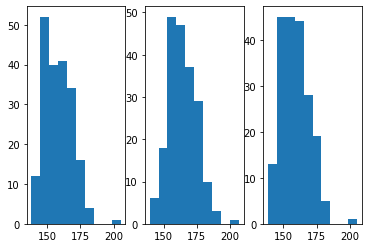

In [2]:
# Background estimation

num_images = 200

modes = np.zeros(num_images)
means = np.zeros(num_images)
medians = np.zeros(num_images)

for i in range(num_images):
    image = skimage.io.imread(f'../data/BBBC039/images_raw/image{i}.tif')
    
    image = skimage.transform.downscale_local_mean(image, factors = (2,2))
    
    low = np.percentile(image, 0.01)
    high = np.percentile(image, 99.99)

    image = np.minimum(image, high)
    image = np.maximum(image, low)
    
    modes[i] = mode(image[image<300]).mode
    means[i] = image[image<300].mean()
    medians[i] = np.median(image[image<300])

fig,ax=plt.subplots(1,3)
_ = ax[0].hist(modes.flatten())
_ = ax[1].hist(means.flatten())
_ = ax[2].hist(medians.flatten())

In [3]:
num_images = 200
dim = 256
images = torch.zeros(num_images, dim, dim)

for i in range(num_images):
    image = skimage.io.imread(f'../data/BBBC039/images_raw/image{i}.tif')
    
    image = skimage.transform.downscale_local_mean(image, factors = (2,2))
    
    high = np.percentile(image, 99.99)
    image = np.minimum(image, high)

    image = image[:dim,:dim]
    
    images[i] = torch.from_numpy(np.array(image, dtype = np.float64)[:dim,:dim])

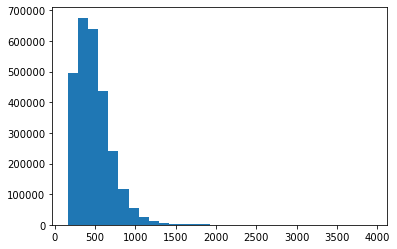

In [4]:
# Fluorescence empirical distribution

background = 160
_ = plt.hist((images[images>(2*background)] - background).flatten().cpu().numpy(), bins = 30)

### Masks

In [5]:
true_counts = torch.zeros(num_images)
masks = torch.zeros(num_images, 2*dim, 2*dim)

for i in range(num_images):
    mask = skimage.io.imread(f'../data/BBBC039/masks_raw/mask{i}.png')
    mask = mask[:(2*dim),:(2*dim),0]
    masks[i] = torch.tensor(skimage.morphology.label(mask))
    true_counts[i] = len(torch.unique(masks[i])) - 1

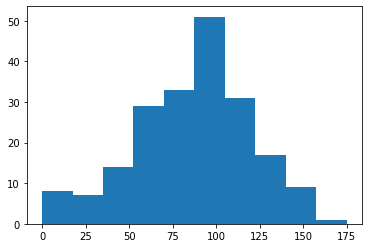

In [6]:
# True counts per pixel
_ = plt.hist(true_counts.cpu().numpy())

### Save tensors

In [7]:
# torch.save(images, '../data/BBBC039/images.pt')
# torch.save(masks, '../data/BBBC039/masks.pt')
# torch.save(true_counts, '../data/BBBC039/true_counts.pt')